In [1]:
import metamol as meta

In [2]:
from metamol.lib.fragments.monomers import CH3, PEGMonomer 
from metamol.lib.molecules.polymer import Polymer 
from metamol.lib.molecules import water

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# 构建聚乙二醇单体 
pegmonomer = PEGMonomer()
pegmonomer.view()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [5]:
#构建聚乙二醇高分子
ch3 = CH3()
PEG = Polymer(name='PEG', monomers=pegmonomer, 
              seq='A', head=ch3, tail=ch3)
PEG.build(N=5)
PEG.embed()
PEG.view()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [6]:
#构建聚乙二醇-水体系
water_spce = water.SPCE()
PEG_water_sys = meta.System(input=[PEG, water_spce], 
                            dup=[5, 50], box=[20, 20, 20])

#分配力场参数
PEG_water_sys.parametrize(forcefield_name='opls')

In [7]:
#生成体系初始构象
PEG_water_sys.initial_config()
PEG_water_sys.view()

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In [8]:
#保存构象为gromacs输入格式
PEG_water_sys.save('PEG_water.top')
PEG_water_sys.save('PEG_water.gro')

In [9]:
#通过metaGromacs进行Gromacs模拟
from metamol.metaGromacs import metaGromacs
mgro = metaGromacs()

# 设置Gromacs模拟参数
mgro.command('title = dppc')
mgro.command('cpp = /lib/cpp')
mgro.command('integrator = md')
mgro.command('nsteps = 2000')
mgro.command('nstlist = 10')

mgro.commands_list(['nstfout = 0', 'nstxout = 0', 'nstvout = 0', 'nstxtcout = 0', 'nstlog = 0'])

mgro.command('dt = 0.001')
mgro.command('constraints = hbonds')
mgro.command('nstenergy = 50')
mgro.command('ns_type = grid')
mgro.command('coulombtype = PME')

mgro.commands_list(['rlist = 0.8', 'rvdw = 0.8', 'rcoulomb = 0.8', 'tcoupl = v-rescale', 'tc_grps = system'])
mgro.command('tau_t = 0.1')
mgro.command('ref_t = 300')
mgro.command('fourier_spacing = 0.125')
mgro.command('nstcalcenergy = 50')
mgro.command('cutoff-scheme = verlet')

In [10]:
#开始Gromacs模拟
mgro.grompp(gro_file='PEG_water.gro', top_file='PEG_water.top')
mgro.mdrun()

Setting the LD random seed to -1782906883

Generated 45 of the 45 non-bonded parameter combinations

Generated 45 of the 45 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'PEG'

turning H bonds into constraints...

Excluding 3 bonded neighbours molecule type 'Water-SPCE'

turning H bonds into constraints...
Analysing residue names:
There are:    55      Other residues
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...

The largest distance between excluded atoms is 0.367 nm

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 0.802 nm, buffer size 0.002 nm

Set rlist, assuming 4x4 atom pair-list, to 0.800 nm, buffer size 0.000 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 16x16x16, spacing 0.125 0.125 0.125

Estimate for the relative computational load of the PME

In [11]:
#通过metaLammps进行Lammps模拟
#保存构象为lammps输入格式(data file)
PEG_water_sys.save('PEG_water.data')

In [12]:
#创建metaLammps对象来管理和运行lammps
from metamol.metaLammps import metaLammps
mlmp = metaLammps()

#读入lammps 指令文件并运行lammps
mlmp.file('PEG_water.in')
mlmp.launch(output='out.dat', mpi=True, nprocs=4, gpu=False)

LAMMPS (23 Jun 2022 - Update 2)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (src/comm.cpp:98)
using 1 OpenMP thread(s) per MPI task
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (src/comm.cpp:98)
using 1 OpenMP thread(s) per MPI task
Reading data file ...
orthogonal box = (0 0 0) to (20 20 20)
1 by 2 by 2 MPI processor grid
reading atoms ...
365 atoms
scanning bonds ...
4 = max bonds/atom
scanning angles ...
6 = max angles/atom
scanning dihedrals ...
15 = max dihedrals/atom
reading bonds ...
310 bonds
reading angles ...
435 angles
reading dihedrals ...
420 dihedrals
Finding 1-2 1-3 1-4 neighbors ...
special bond factors lj:    0        0        0
special bond factors coul:  0        0        0
4 = max # of 1-2 neighbors
6 = max # of 1-3 neighbors
12 = max # of 1-4 neighbors
14 = max # of special neighbors
special bonds CPU = 0.000 seconds
read_data CPU = 0.013 seconds
Finding 1-2 1-3 1-4 neighbors ...
special bond factors lj:    0        0        0

Text(0, 0.5, 'Temperature(K)')

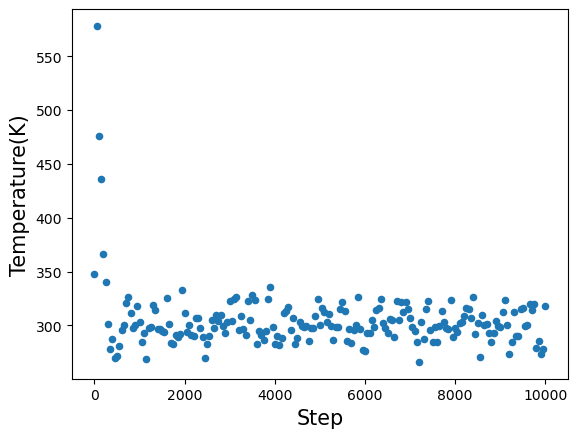

In [13]:
import matplotlib.pyplot as plt
#模拟数据读取和处理
#温度随步数的变化趋势
temp_out = mlmp.get_thermo('Temp')
temp_out.plot(x='Step', y='Temp', kind='scatter')
plt.xlabel('Step', fontsize=15)
plt.ylabel('Temperature(K)', fontsize=15)

Text(0, 0.5, 'Potential Energy(Kcal/mole)')

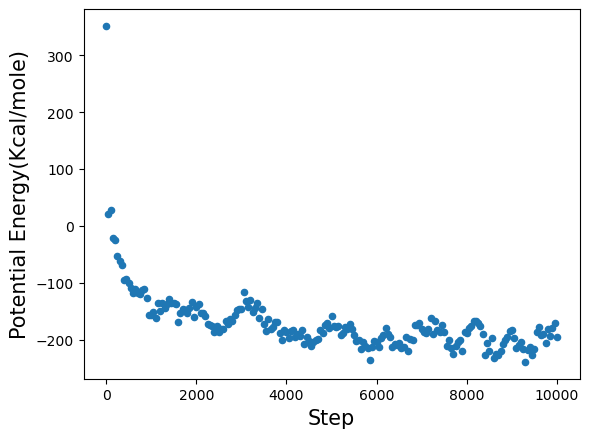

In [14]:
#体系势能随步数的变化趋势
pe_out = mlmp.get_thermo('PotEng')
pe_out.plot(x='Step', y='PotEng', kind='scatter')
plt.xlabel('Step', fontsize=15)
plt.ylabel('Potential Energy(Kcal/mole)', fontsize=15)

In [15]:
#清理模拟输出文件
mlmp.close()
import os
onlyfiles = [f for f in os.listdir() if os.path.isfile(f)]

for f in onlyfiles:
    if f not in ['PEG_water.py', 'PEG_water.in', 'PEG_water.ipynb']:
        os.remove(f)